# Detección de anomalias
**Proyecto:** 3  
**Equipo:**  
    -Ibsan Otniel Morales Yepiz  
    -Hugo de Jesús Valenzuela Chaparro  
    -Héctor Rodríguez Domínguez  
    
### Descripción de Datos
   -El dataset empleado para este proyecto se obutvo de la plataforma de Kaggle en el siguiente enlace: https://www.kaggle.com/tangodelta/api-access-behaviour-anomaly-dataset
    
   -El dataset contine las sisguientes columnas:  
    
   <ul>
    <li>**inter_api_access_duration(sec):** Intervalo de tiempo entre dos accesos consecutivos en la sesión de un usuario  </li>
    <li>**api_access_uniqueness:** La proporción de diferentes APIs utilzadas con relación a las APIs utilizadas en la sesión de un usuario  </li>
    <li>**sequence_length(count):** Promedio de llamadas que un usuario hace en una sesión  </li>
    <li>**vsession_duration(min):** Duración de una sesión en minutos   </li>
    <li>**ip_type:** Tipo de ip de donde proviene el usuario  </li>
    <li>**behavior:** subtipo de comportamiento  </li>
    <li>**behavior_type:** Tipo de comportamiento  </li>
    <li>**num_sessions:** Numeor de sesiónes con diferente id de sesión  </li>
    <li>**num_users:** NUmero de usuarios realizando el mismo tipo de llamadas a la API  </li>
    <li>**num_unique_apis:** Número de APIs distintas en el mismo grupo de ocmportamiento  </li>
    <li>**source:** Origen de la información  </li>
    </ul>
    

### Importando librerias

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns
from pandas_profiling import ProfileReport 
from sklearn.neighbors import LocalOutlierFactor
import sweetviz

### Lectura y preparación de datos

In [10]:
#Read file
df = pd.read_csv("data/remaining_behavior_ext.csv")

#Rename columns according to our preference
df.rename(
    columns={"inter_api_access_duration(sec)": "access_duration", "api_access_uniqueness": "access_uniqueness",
             "sequence_length(count)": "session_calls", "vsession_duration(min)": "session_duration" }, 
    inplace=True
)

#Pop useless columns for our intention
df.pop("ip_type")
df.pop("behavior")
df.pop("num_sessions")
df.pop("num_unique_apis")
df.pop("source")

#we remove unnamed column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#We assign a nuemrical value to behavior_type column
#df["behavior_type"].replace({"attack": 1, "bot": 2, "normal": 3, "outlier": 4}, inplace=True)

#We transform minutes to seconds in order to normalize the DF
df["session_duration"] = 60 * df["session_duration"]


df.head()

access_duration  access_uniqueness  session_calls  session_duration  \
0         7.010387           0.419355           31.0            782400   
1        51.419393           0.252336          107.0          19806780   
2        25.860775           0.275000           40.0           3723960   
3         0.205909           0.818182           11.0              8160   
4         0.122125           0.812500           16.0              7080   

  behavior_type  num_users  
0       outlier        1.0  
1       outlier        1.0  
2       outlier        1.0  
3       outlier        1.0  
4       outlier        1.0

### Análisis exploratorio
En esta sección se revisa la información de la estrucutra general de nuestro dataframe, asi como datos generales de este.  

**La forma de nuestro dataframe:** 

In [11]:
df.shape

(34562, 6)

**Tipos de datos:**  

In [12]:
df.dtypes

access_duration      float64
access_uniqueness    float64
session_calls        float64
session_duration       int64
behavior_type         object
num_users            float64
dtype: object

**Valores perdidos, repetidos y NaN:**  

In [13]:
#Valores vacios
df.isnull().sum()

access_duration      5
access_uniqueness    5
session_calls        0
session_duration     0
behavior_type        0
num_users            0
dtype: int64

In [14]:
#We remove rows with null values
df = df.dropna()
print("Dataset despues de quitar valores nulos")
df.isnull().sum()

Dataset despues de quitar valores nulos


access_duration      0
access_uniqueness    0
session_calls        0
session_duration     0
behavior_type        0
num_users            0
dtype: int64

In [15]:
#Eliminar valores NaN
df.dropna(inplace=True)

#Valores duplicados
print(df.duplicated().sum())

1179


In [16]:
#Eliminamos filas con valores duplicados
df.drop_duplicates(keep='last',inplace=True)
print(df.duplicated().sum())

0


**Mapa de correlación**  
En esta sección se muestra un mapa de calor, donde podemos observar que no hay una correlación importante entre las diferentes columnas del dataset



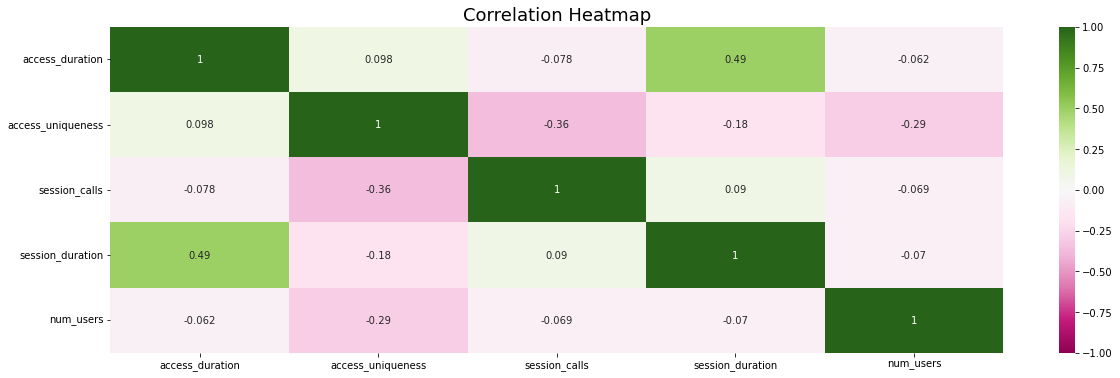

In [17]:
plt.figure(figsize=(20,6))
hm = sns.heatmap(df.corr(),vmin=-1, vmax=1, annot=True,cmap='PiYG')
hm.set_title('Correlation Heatmap',  fontdict={'fontsize':18});
plt.show()

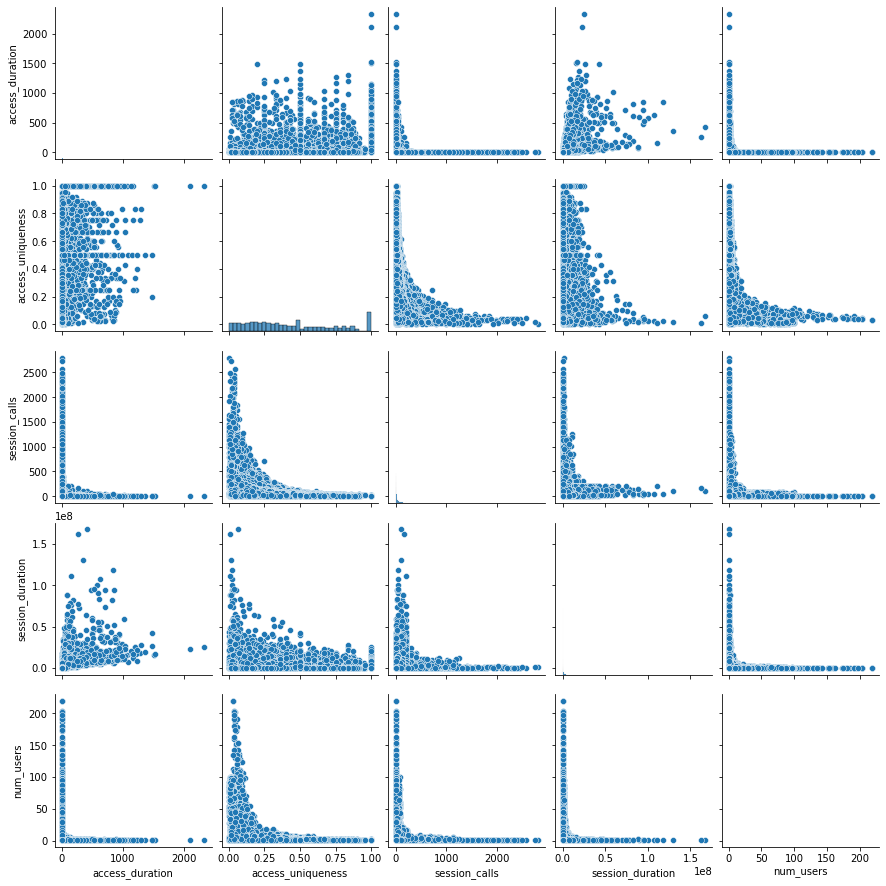

In [18]:
sns.pairplot(df) 
plt.show()

#### Descripción de datos

In [19]:
df.groupby('behavior_type').agg(['mean','min', 'max'])

access_duration                        access_uniqueness  \
                         mean       min          max              mean   
behavior_type                                                            
attack              34.116884  5.522434   112.015222          0.284409   
bot                 28.081147  0.000000  1483.934200          0.258468   
normal               8.481570  0.000000   889.360833          0.246879   
outlier             25.346105  0.000000  2333.627333          0.518783   

                                  session_calls                \
                    min       max          mean   min     max   
behavior_type                                                   
attack         0.075472  0.846154    115.818182  13.0   200.0   
bot            0.003356  1.000000     30.845778   1.0   596.0   
normal         0.000714  0.900000     31.263716   1.5  1253.5   
outlier        0.000714  1.000000     80.438993   1.0  2800.0   

              session_duration                     num_users              
                          mean     min        max       mean  min    max  
behavior_type                                                             
attack            9.582289e+06  457920   12834720   1.090909  1.0    3.0  
bot               2.747629e+06       0   75991320  14.749538  1.0  219.0  
normal            9.918520e+05       0   88603680   9.394684  2.0  100.0  
outlier           2.040443e+06       0  167251800   1.000000  1.0    1.0

#### Creación de perfil con "sweetviz"

In [20]:
df_profile = ProfileReport(
    df, 
    explorative=True,
    title='Comportamiento de dataframe', 
    html={'style':{'full_width':False}}
) 

df_profile.to_file("profile.html")

B_profile = sweetviz.analyze(df)
B_profile.show_html("profile.html")

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

                                             |          | [  0%]   00:00 -> (? left)

Report profile.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Basados en la información previamente obtenida en el análisis del dataset, queremos detectar las anomalias en el tiempo que transcurre entre cada llamada a una API, para determinar si es un bot.

#### Local Outlier factor

El factor atípico local es un algoritmo propuesto para encontrar puntos de datos anómalos midiendo la desviación local de un punto de datos dado con respecto a sus vecinos.

In [21]:
df["behavior_type"].replace({"attack": 1, "bot": 2, "normal": 3, "outlier": 4}, inplace=True)

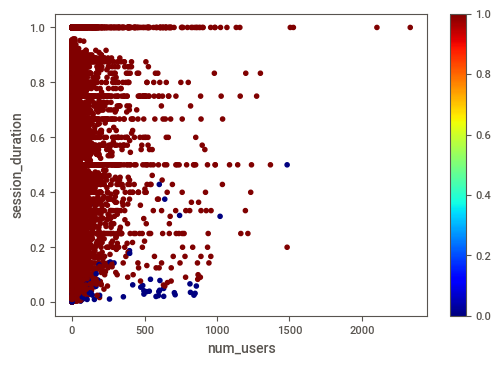

In [22]:
clf = LocalOutlierFactor(n_neighbors=100)
estimado_LOF = clf.fit_predict(df)

plt.scatter(x=df.iloc[:,0], y=df.iloc[:,1], c=np.where(estimado_LOF > 0.0,1,0), cmap='jet')
#plt.scatter(x=X[:,0], y=X[:,1], c=estimado_LOF, cmap='jet')
plt.xlabel("num_users")
plt.ylabel("session_duration")
plt.colorbar()
plt.show()

In [23]:
np.where(estimado_LOF > 0.0,1,0).mean()

0.9845407154413086

#### Isolation Forest
Es una método no supervisado para identificar anomalías (outliers) cuando los datos no están etiquetados, es decir, no se conoce la clasificación real (anomalía - no anomalía) de las observaciones. 

Su funcionamiento está inspirado en el algoritmo de clasificación y regresión Random Forest

In [26]:
random_state = np.random.RandomState(43)
model=IsolationForest(n_estimators=50, contamination=float(0.9), warm_start=True, random_state=random_state)

#model = IsolationForest(n_estimators=50, warm_start=True)
model.fit(df[['access_duration']])

df['scores'] = model.decision_function(df[['access_duration']])

df['anomaly_score'] = model.predict(df[['access_duration']])

#print(df[df['anomaly_score']==-1].head(20))
#df[df['anomaly_score']==-1].tail(20) 

anomaly_count = df.shape[0]
    
accuracy = 100*list(df['anomaly_score']).count(-1)/anomaly_count
#accuracy = df[df['anomaly_score']==-1].head()
print("Accuracy of the model:", accuracy)

plt.scatter(x=df.iloc[:,0], y=df.iloc[:,1], c=df['scores'], cmap='jet')
plt.colorbar()
plt.show()

ValueError: contamination must be in (0, 0.5], got: 0.900000

#### Conclusiones

Como se puede observar, este dataset presenta casos muy especiales donde los valores cercanos al 0 se presentan como valores anomales fdebido a la rapides de acceso entre las aplicaciones

Asimismo no existe mucha correlacion entre las diferente variables, por lo cual se decidio trabajar con la columna de "access_duration", la cual tiene una mayor correlación con "session_duration" como se muestra en los pair plots.

Contemplando los resultados entre ambos metodos, se puede observar que el mejor resultado se obtiene a traves del uso del Local Outlier factor. debido a que se ajusta mejor por los vecinos y cercania de los valores en de

***

# Conjunto de Datos con etiquetado
En esta siguiente sección se usa el otro dataset, llamado ```supervised_dataset```, el cual contiene ya etiquetado si es outlier o no. Sin embargo en este proyecto se ignora el etiquetado y se aplican los métodos de detección de anomalías como si no se tuviesen.

### Diccionario de los datos
- **inter_api_access_duration(sec):** Intervalo de tiempo entre dos accesos consecutivos a la API en una sesión de usuario.
- **api_access_uniqueness:** La proporción del número de APIs distintas vistas en una sesión de un usuario con respecto al total de llamadas hechas a la API en esa sesión.
- **sequence_length(count):** El número total de llamadas a API hechas en una sesión por una usuario en promedio.
- **vsession_duration(min):** La duración de una sesión de usuario dentro de una ventana de observación en minutos.
- **ip_type:** El tipo de IP de donde proviene el usuario.
- **num_sessions:** Número de sesiones de usuario cada una con diferente session_id.
- **num_users:** Número de usuarios generando el mismo tipo de secuencias de llamadas de API.
- **num_unique_apis:** Número de APIs distintas en ese grupo de comportamiento (behavior group).
- **source:** Origen de los datos. F = Financial services, E = Ecommerce.
- **classification:** Clasificación, outlier o normal.

# Local Outlier Factor

## CARGA DE DATOS

In [28]:
dfsup = pd.read_csv('./data/supervised_dataset.csv')

In [29]:
dfsup

Unnamed: 0  inter_api_access_duration(sec)  api_access_uniqueness  \
0              0                        0.000812               0.004066   
1              1                        0.000063               0.002211   
2              2                        0.004481               0.015324   
3              3                        0.017837               0.014974   
4              4                        0.000797               0.006056   
...          ...                             ...                    ...   
1555        1555                        9.324284               0.405405   
1556        1556                        9.141667               1.000000   
1557        1557                        4.177931               0.170213   
1558        1558                        9.253941               0.764706   
1559        1559                        7.797227               0.818182   

      sequence_length(count)  vsession_duration(min)  ip_type  num_sessions  \
0                  85.643243                    5405  default        1460.0   
1                  16.166805                     519  default        9299.0   
2                  99.573276                    6211  default         255.0   
3                  69.792793                    8292  default         195.0   
4                  14.952756                     182  default         272.0   
...                      ...                     ...      ...           ...   
1555               37.000000                   20700  default           2.0   
1556                6.000000                    3291  default           2.0   
1557               94.000000                   23564  default           2.0   
1558               17.000000                    9440  default           2.0   
1559               11.000000                    5147  default           2.0   

      num_users  num_unique_apis source classification  
0        1295.0            451.0      E         normal  
1        8447.0            302.0      E         normal  
2         232.0            354.0      E         normal  
3         111.0            116.0      E         normal  
4         254.0             23.0      E         normal  
...         ...              ...    ...            ...  
1555        1.0             15.0      F        outlier  
1556        1.0              6.0      F        outlier  
1557        1.0             16.0      F        outlier  
1558        1.0             13.0      F        outlier  
1559        1.0              9.0      F        outlier  

[1560 rows x 11 columns]

## ANALISIS EXPLORATORIO

### ESTRUCTURA DE DATOS

In [30]:
dfsup.shape

(1560, 11)

In [31]:
#Estructura de datos
dfsup.dtypes

Unnamed: 0                          int64
inter_api_access_duration(sec)    float64
api_access_uniqueness             float64
sequence_length(count)            float64
vsession_duration(min)              int64
ip_type                            object
num_sessions                      float64
num_users                         float64
num_unique_apis                   float64
source                             object
classification                     object
dtype: object

In [32]:
dfsup.describe()

Unnamed: 0  inter_api_access_duration(sec)  api_access_uniqueness  \
count  1560.000000                     1560.000000            1560.000000   
mean    779.500000                        0.858996               0.153479   
std     450.477524                        4.875142               0.275511   
min       0.000000                        0.000003               0.001200   
25%     389.750000                        0.000638               0.008701   
50%     779.500000                        0.001831               0.016063   
75%    1169.250000                        0.015128               0.137941   
max    1559.000000                       84.045074               1.000000   

       sequence_length(count)  vsession_duration(min)  num_sessions  \
count             1560.000000            1.560000e+03   1560.000000   
mean                58.215141            6.297617e+03    614.283333   
std                185.849968            4.847140e+04   1219.123408   
min                  2.000000            1.000000e+00      2.000000   
25%                 10.183704            7.075000e+01     13.000000   
50%                 17.000000            1.935000e+02    187.000000   
75%                 38.331612            4.010750e+03    531.000000   
max               3303.000000            1.352948e+06   9299.000000   

         num_users  num_unique_apis  
count  1560.000000      1560.000000  
mean    442.373718        72.175000  
std     994.647978        83.891631  
min       1.000000         1.000000  
25%       1.000000        16.000000  
50%     155.000000        42.000000  
75%     356.250000        97.000000  
max    8447.000000       524.000000

### Valores Perdidos

In [33]:
dfsup.isnull().sum()

Unnamed: 0                        0
inter_api_access_duration(sec)    0
api_access_uniqueness             0
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64

In [34]:
dfsup.isna().sum()

Unnamed: 0                        0
inter_api_access_duration(sec)    0
api_access_uniqueness             0
sequence_length(count)            0
vsession_duration(min)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64

In [35]:
#Drop Nans
dftidy = dfsup.dropna()
#Drop Unnamed classification column
dftidy =dftidy.drop(['classification'], axis=1)
dftidy =dftidy.drop(dftidy.columns[[0]], axis=1)
#Make Columns type Factor
dftidy['source'] = dftidy['source'].astype('category')
dftidy['ip_type'] = dftidy['ip_type'].astype('category')
#dftidy.isna().sum()
dftidy.dtypes

inter_api_access_duration(sec)     float64
api_access_uniqueness              float64
sequence_length(count)             float64
vsession_duration(min)               int64
ip_type                           category
num_sessions                       float64
num_users                          float64
num_unique_apis                    float64
source                            category
dtype: object

In [36]:
dftidy.shape

(1560, 9)

NameError: name 'heatmap' is not defined

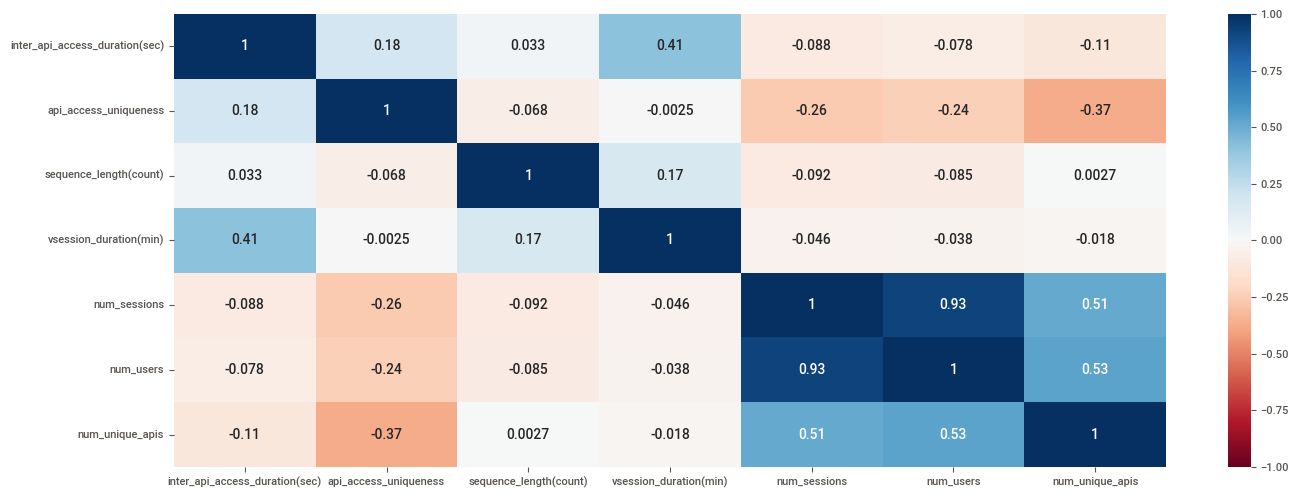

In [37]:
plt.figure(figsize=(16,6))
sns.heatmap(dftidy.corr(),vmin=-1, vmax=1, annot=True,cmap='RdBu')
heatmap.set_title('Correlacion Heatmap', fontdict={'fontsize':18}, pad=12);
plt.show()

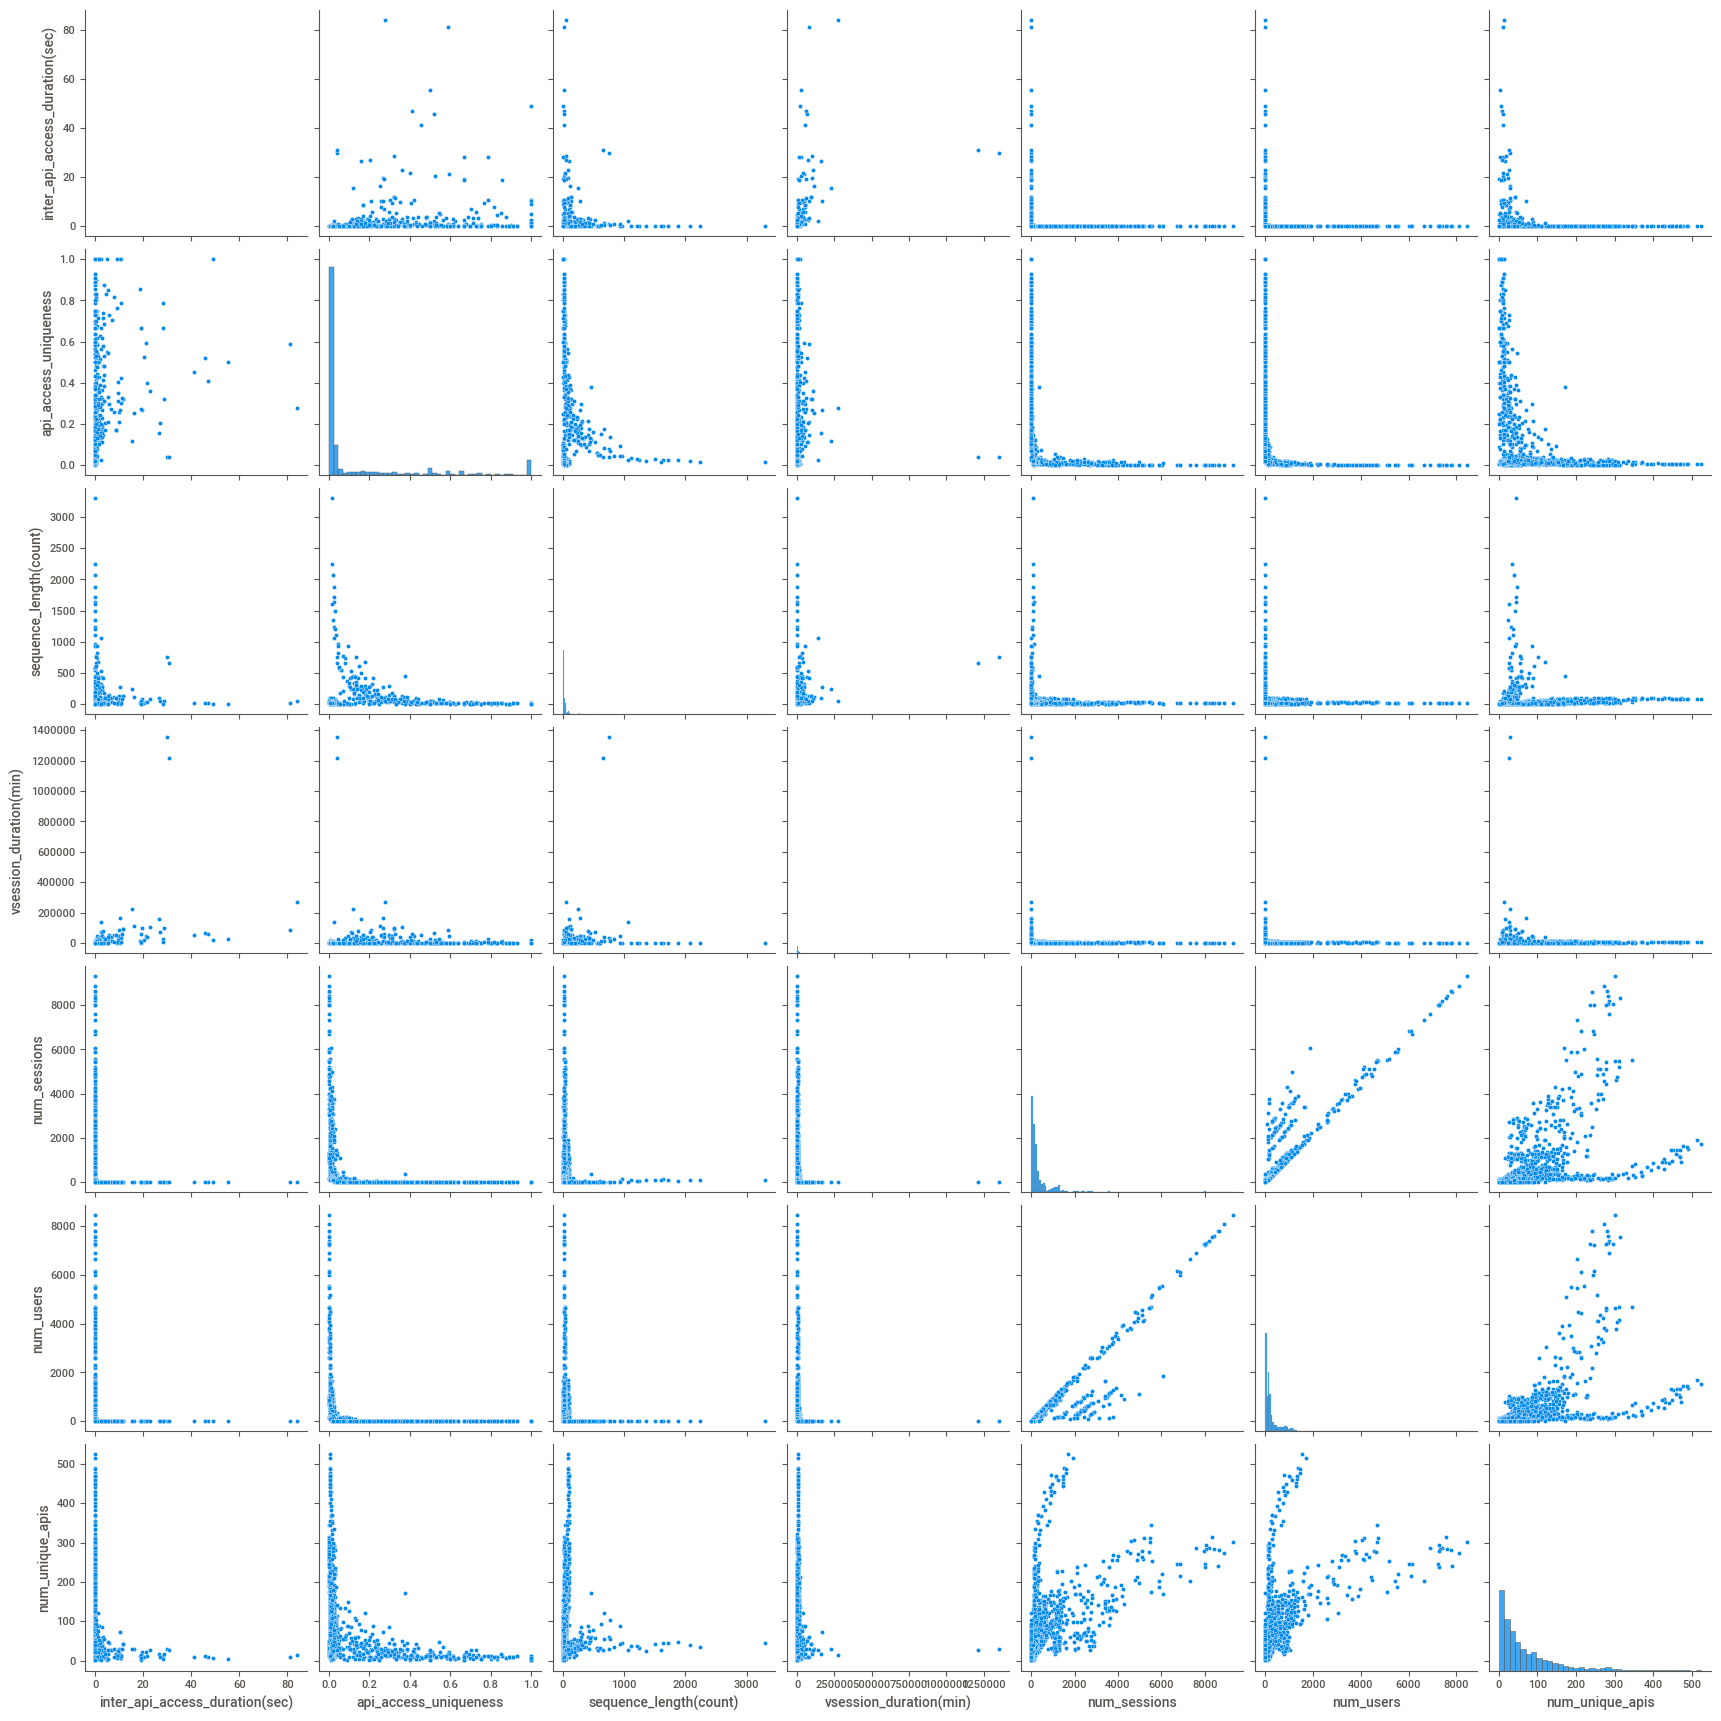

In [38]:
sns.pairplot(dftidy) 
plt.show()

## LOCAL OUTLIER FACTOR

In [39]:
X = dftidy[["num_users", "inter_api_access_duration(sec)"]].to_numpy()
X.shape

(1560, 2)

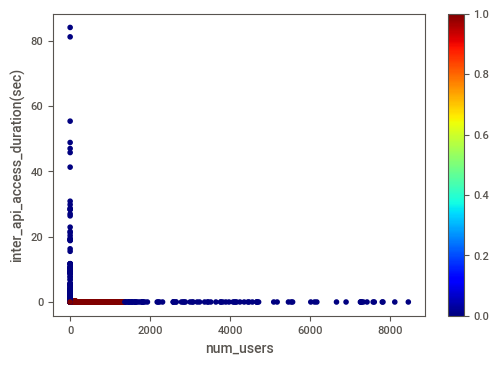

In [40]:
clf = LocalOutlierFactor(n_neighbors=100)
estimado_LOF = clf.fit_predict(X)

plt.scatter(x=X[:,0], y=X[:,1], c=np.where(estimado_LOF > 0.0,1,0), cmap='jet')
#plt.scatter(x=X[:,0], y=X[:,1], c=estimado_LOF, cmap='jet')
plt.xlabel("num_users")
plt.ylabel("inter_api_access_duration(sec)")
plt.colorbar()
plt.show()

In [41]:
np.where(estimado_LOF > 0.0,1,0).mean() 

0.7551282051282051

***

# One-Class Support Vector Machine

## Leyendo datos

In [42]:
# leyendo datos
df_sup = pd.read_csv("./data/supervised_dataset.csv", index_col=0)

### Descripción de las variables


In [43]:
df_sup.dtypes

inter_api_access_duration(sec)    float64
api_access_uniqueness             float64
sequence_length(count)            float64
vsession_duration(min)              int64
ip_type                            object
num_sessions                      float64
num_users                         float64
num_unique_apis                   float64
source                             object
classification                     object
dtype: object

In [44]:
# cambiando la variable vsession_duration a segundos para que sea comparable
df_sup.rename(
    columns={"vsession_duration(min)": "vsession_duration(sec)" }, 
    inplace=True
)
df_sup['vsession_duration(sec)'] = df_sup['vsession_duration(sec)'] * 60

In [45]:
# categorizando las variables de categoria
for col in ['ip_type', 'source', 'classification']:
    df_sup[col] = df_sup[col].astype('category')
df_sup.dtypes

inter_api_access_duration(sec)     float64
api_access_uniqueness              float64
sequence_length(count)             float64
vsession_duration(sec)               int64
ip_type                           category
num_sessions                       float64
num_users                          float64
num_unique_apis                    float64
source                            category
classification                    category
dtype: object

In [46]:
# descripción de las características numéricas
df_sup.describe()

inter_api_access_duration(sec)  api_access_uniqueness  \
count                     1560.000000            1560.000000   
mean                         0.858996               0.153479   
std                          4.875142               0.275511   
min                          0.000003               0.001200   
25%                          0.000638               0.008701   
50%                          0.001831               0.016063   
75%                          0.015128               0.137941   
max                         84.045074               1.000000   

       sequence_length(count)  vsession_duration(sec)  num_sessions  \
count             1560.000000            1.560000e+03   1560.000000   
mean                58.215141            3.778570e+05    614.283333   
std                185.849968            2.908284e+06   1219.123408   
min                  2.000000            6.000000e+01      2.000000   
25%                 10.183704            4.245000e+03     13.000000   
50%                 17.000000            1.161000e+04    187.000000   
75%                 38.331612            2.406450e+05    531.000000   
max               3303.000000            8.117688e+07   9299.000000   

         num_users  num_unique_apis  
count  1560.000000      1560.000000  
mean    442.373718        72.175000  
std     994.647978        83.891631  
min       1.000000         1.000000  
25%       1.000000        16.000000  
50%     155.000000        42.000000  
75%     356.250000        97.000000  
max    8447.000000       524.000000

In [47]:
# No hay valores perdidos
df_sup.isna().sum()

inter_api_access_duration(sec)    0
api_access_uniqueness             0
sequence_length(count)            0
vsession_duration(sec)            0
ip_type                           0
num_sessions                      0
num_users                         0
num_unique_apis                   0
source                            0
classification                    0
dtype: int64

In [48]:
# se retiran los valores duplicados
df_sup.duplicated().sum()

26

In [49]:
df_sup = df_sup.drop_duplicates()
df_sup.duplicated().sum()

0

### Visualizaciones

In [50]:
# dataframe con solo columnas numericas
df_sup_num = df_sup.drop(['ip_type','source', 'classification'], axis=1)

In [51]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df_sup, title="Pandas Profiling Report")

In [52]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

No se observa normalidad en las columnas numéricas, por lo que no sirviría el método de curva elíptica.

Veamos primero un par de interacciones de variables.

<AxesSubplot:xlabel='num_users', ylabel='num_sessions'>

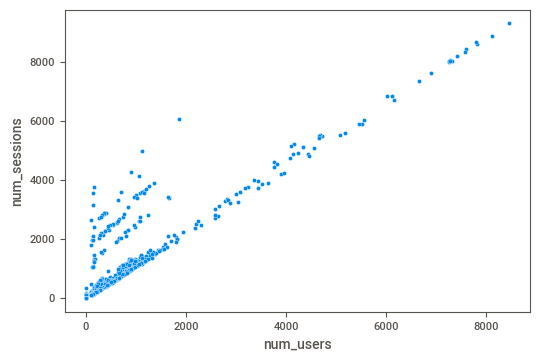

In [53]:
# numero de usuarios vs numero de sesion
sns.scatterplot(data=df_sup_num, x = 'num_users', y = 'num_sessions')

In [54]:
df_sup_num.head()

inter_api_access_duration(sec)  api_access_uniqueness  \
0                        0.000812               0.004066   
1                        0.000063               0.002211   
2                        0.004481               0.015324   
3                        0.017837               0.014974   
4                        0.000797               0.006056   

   sequence_length(count)  vsession_duration(sec)  num_sessions  num_users  \
0               85.643243                  324300        1460.0     1295.0   
1               16.166805                   31140        9299.0     8447.0   
2               99.573276                  372660         255.0      232.0   
3               69.792793                  497520         195.0      111.0   
4               14.952756                   10920         272.0      254.0   

   num_unique_apis  
0            451.0  
1            302.0  
2            354.0  
3            116.0  
4             23.0

In [55]:
df_sup_num.dtypes

inter_api_access_duration(sec)    float64
api_access_uniqueness             float64
sequence_length(count)            float64
vsession_duration(sec)              int64
num_sessions                      float64
num_users                         float64
num_unique_apis                   float64
dtype: object

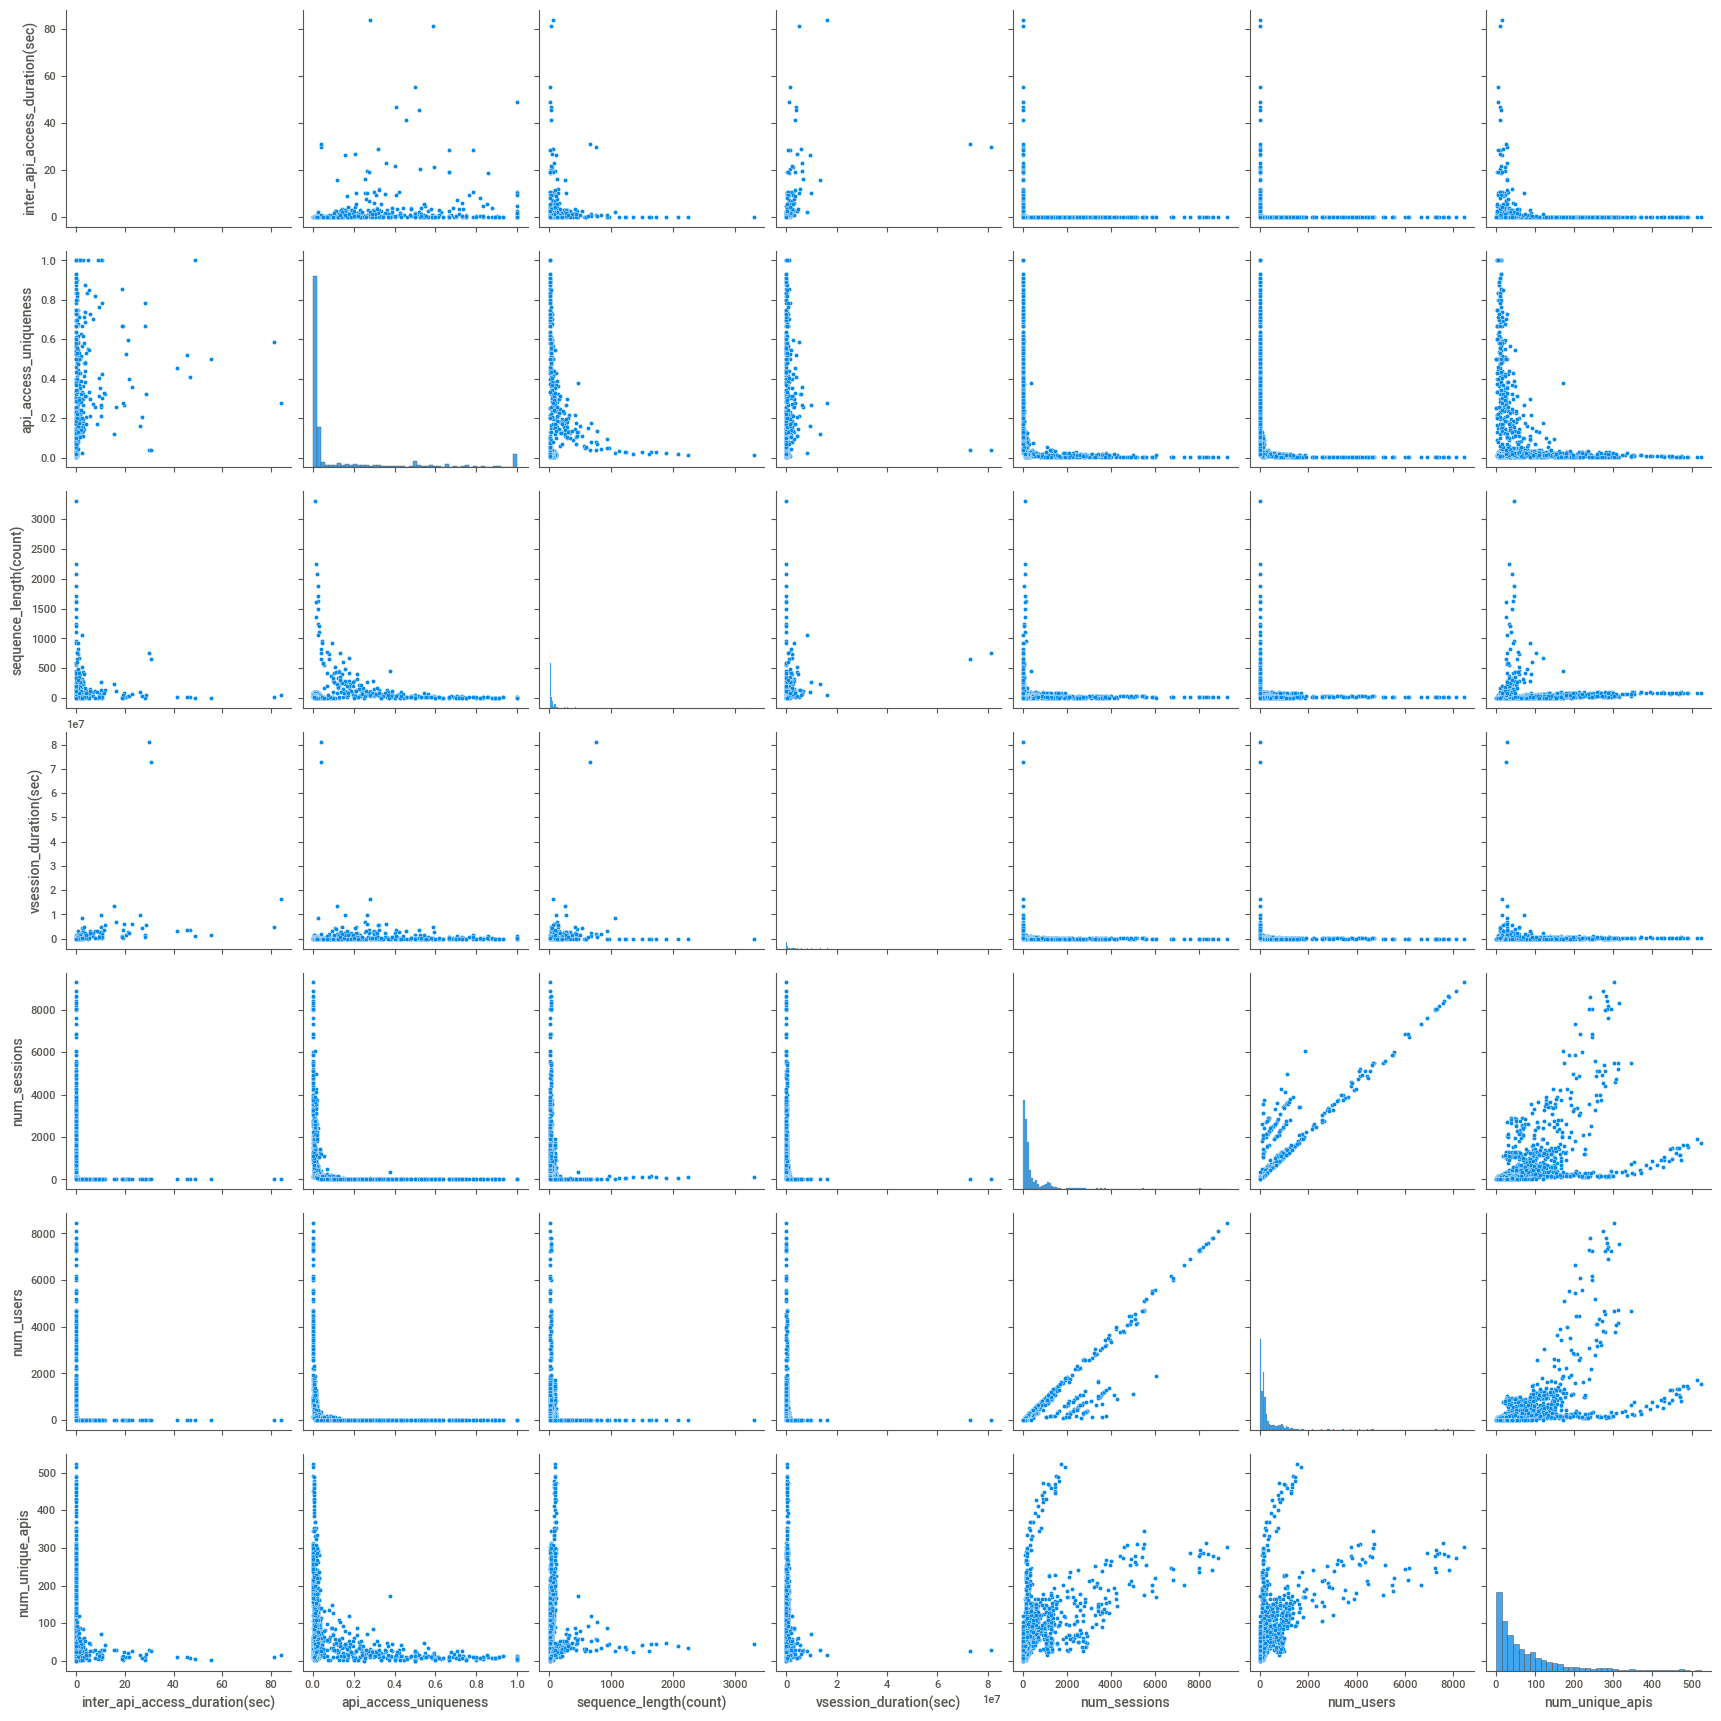

In [56]:
sns.pairplot(data=df_sup_num)

## Detección de Anomalías

### One-Class Support Vector Machine

In [57]:
# importar el modulo desde scikit learn
from sklearn.svm import OneClassSVM

In [99]:
# ajustar el hiperparametro
clf = OneClassSVM(nu=0.15, kernel='rbf')

In [100]:
# predicciones de los outliers
# el método regresa 1 para no outliers y -1 para outliers
y_outlier = clf.fit_predict(df_sup_num)

In [101]:
y_outlier.shape

(1534,)

In [102]:
np.unique(y_outlier, return_counts=True)

(array([-1,  1]), array([ 231, 1303]))

In [103]:
# agregar la columna con las predicciones a nuevo dataframe, codificadas como outlier, normal
df_pred = df_sup_num.copy()
df_pred['y_outlier'] = np.where(y_outlier > 0, 'normal', 'outlier')
df_pred['y_outlier'] = df_pred['y_outlier'].astype('category')

In [104]:
df_pred.head()

inter_api_access_duration(sec)  api_access_uniqueness  \
0                        0.000812               0.004066   
1                        0.000063               0.002211   
2                        0.004481               0.015324   
3                        0.017837               0.014974   
4                        0.000797               0.006056   

   sequence_length(count)  vsession_duration(sec)  num_sessions  num_users  \
0               85.643243                  324300        1460.0     1295.0   
1               16.166805                   31140        9299.0     8447.0   
2               99.573276                  372660         255.0      232.0   
3               69.792793                  497520         195.0      111.0   
4               14.952756                   10920         272.0      254.0   

   num_unique_apis y_outlier  
0            451.0    normal  
1            302.0    normal  
2            354.0    normal  
3            116.0    normal  
4             23.0    normal

### Graficación de los outliers

In [ ]:
sns.pairplot(data=df_pred, hue = 'y_outlier')

In [65]:
df_pred.dtypes

inter_api_access_duration(sec)     float64
api_access_uniqueness              float64
sequence_length(count)             float64
vsession_duration(sec)               int64
num_sessions                       float64
num_users                          float64
num_unique_apis                    float64
y_outlier                         category
dtype: object

### Considerando solamente 4 características en el ajuste del One-Class SVM

- **inter_api_access_duration(sec):** Intervalo de tiempo entre dos accesos consecutivos a la API en una sesión de usuario.
- **sequence_length(count):** El número total de llamadas a API hechas en una sesión por una usuario en promedio.

- **num_sessions:** Número de sesiones de usuario cada una con diferente session_id.
- **num_users:** Número de usuarios generando el mismo tipo de secuencias de llamadas de API.

#### El dataframe

In [86]:
# dataframe con las 4 características
df_subset = df_sup_num.copy()
df_subset = df_subset[['num_users','num_sessions', 'sequence_length(count)', 'inter_api_access_duration(sec)']]
#df_subset = df_subset[['num_users','num_sessions', 'inter_api_access_duration(sec)']]
#df_subset = df_subset[['num_users','num_sessions']]
df_subset.head()

num_users  num_sessions  sequence_length(count)  \
0     1295.0        1460.0               85.643243   
1     8447.0        9299.0               16.166805   
2      232.0         255.0               99.573276   
3      111.0         195.0               69.792793   
4      254.0         272.0               14.952756   

   inter_api_access_duration(sec)  
0                        0.000812  
1                        0.000063  
2                        0.004481  
3                        0.017837  
4                        0.000797

In [87]:
# ajustar el hiperparametro
clf = OneClassSVM(nu=0.15, kernel='rbf')
# predicciones de los outliers
# el método regresa 1 para no outliers y -1 para outliers
y_outlier = clf.fit_predict(df_subset)

In [88]:
y_outlier.shape

(1534,)

In [89]:
np.unique(y_outlier, return_counts=True)

(array([-1,  1]), array([ 232, 1302]))

In [90]:
# agregar la columna con las predicciones a nuevo dataframe, codificadas como outlier, normal
df_pred = df_sup_num.copy()
df_pred['y_outlier'] = np.where(y_outlier > 0, 'normal', 'outlier')
df_pred['y_outlier'] = df_pred['y_outlier'].astype('category')

In [91]:
df_pred.head()

inter_api_access_duration(sec)  api_access_uniqueness  \
0                        0.000812               0.004066   
1                        0.000063               0.002211   
2                        0.004481               0.015324   
3                        0.017837               0.014974   
4                        0.000797               0.006056   

   sequence_length(count)  vsession_duration(sec)  num_sessions  num_users  \
0               85.643243                  324300        1460.0     1295.0   
1               16.166805                   31140        9299.0     8447.0   
2               99.573276                  372660         255.0      232.0   
3               69.792793                  497520         195.0      111.0   
4               14.952756                   10920         272.0      254.0   

   num_unique_apis y_outlier  
0            451.0   outlier  
1            302.0   outlier  
2            354.0    normal  
3            116.0    normal  
4             23.0    normal

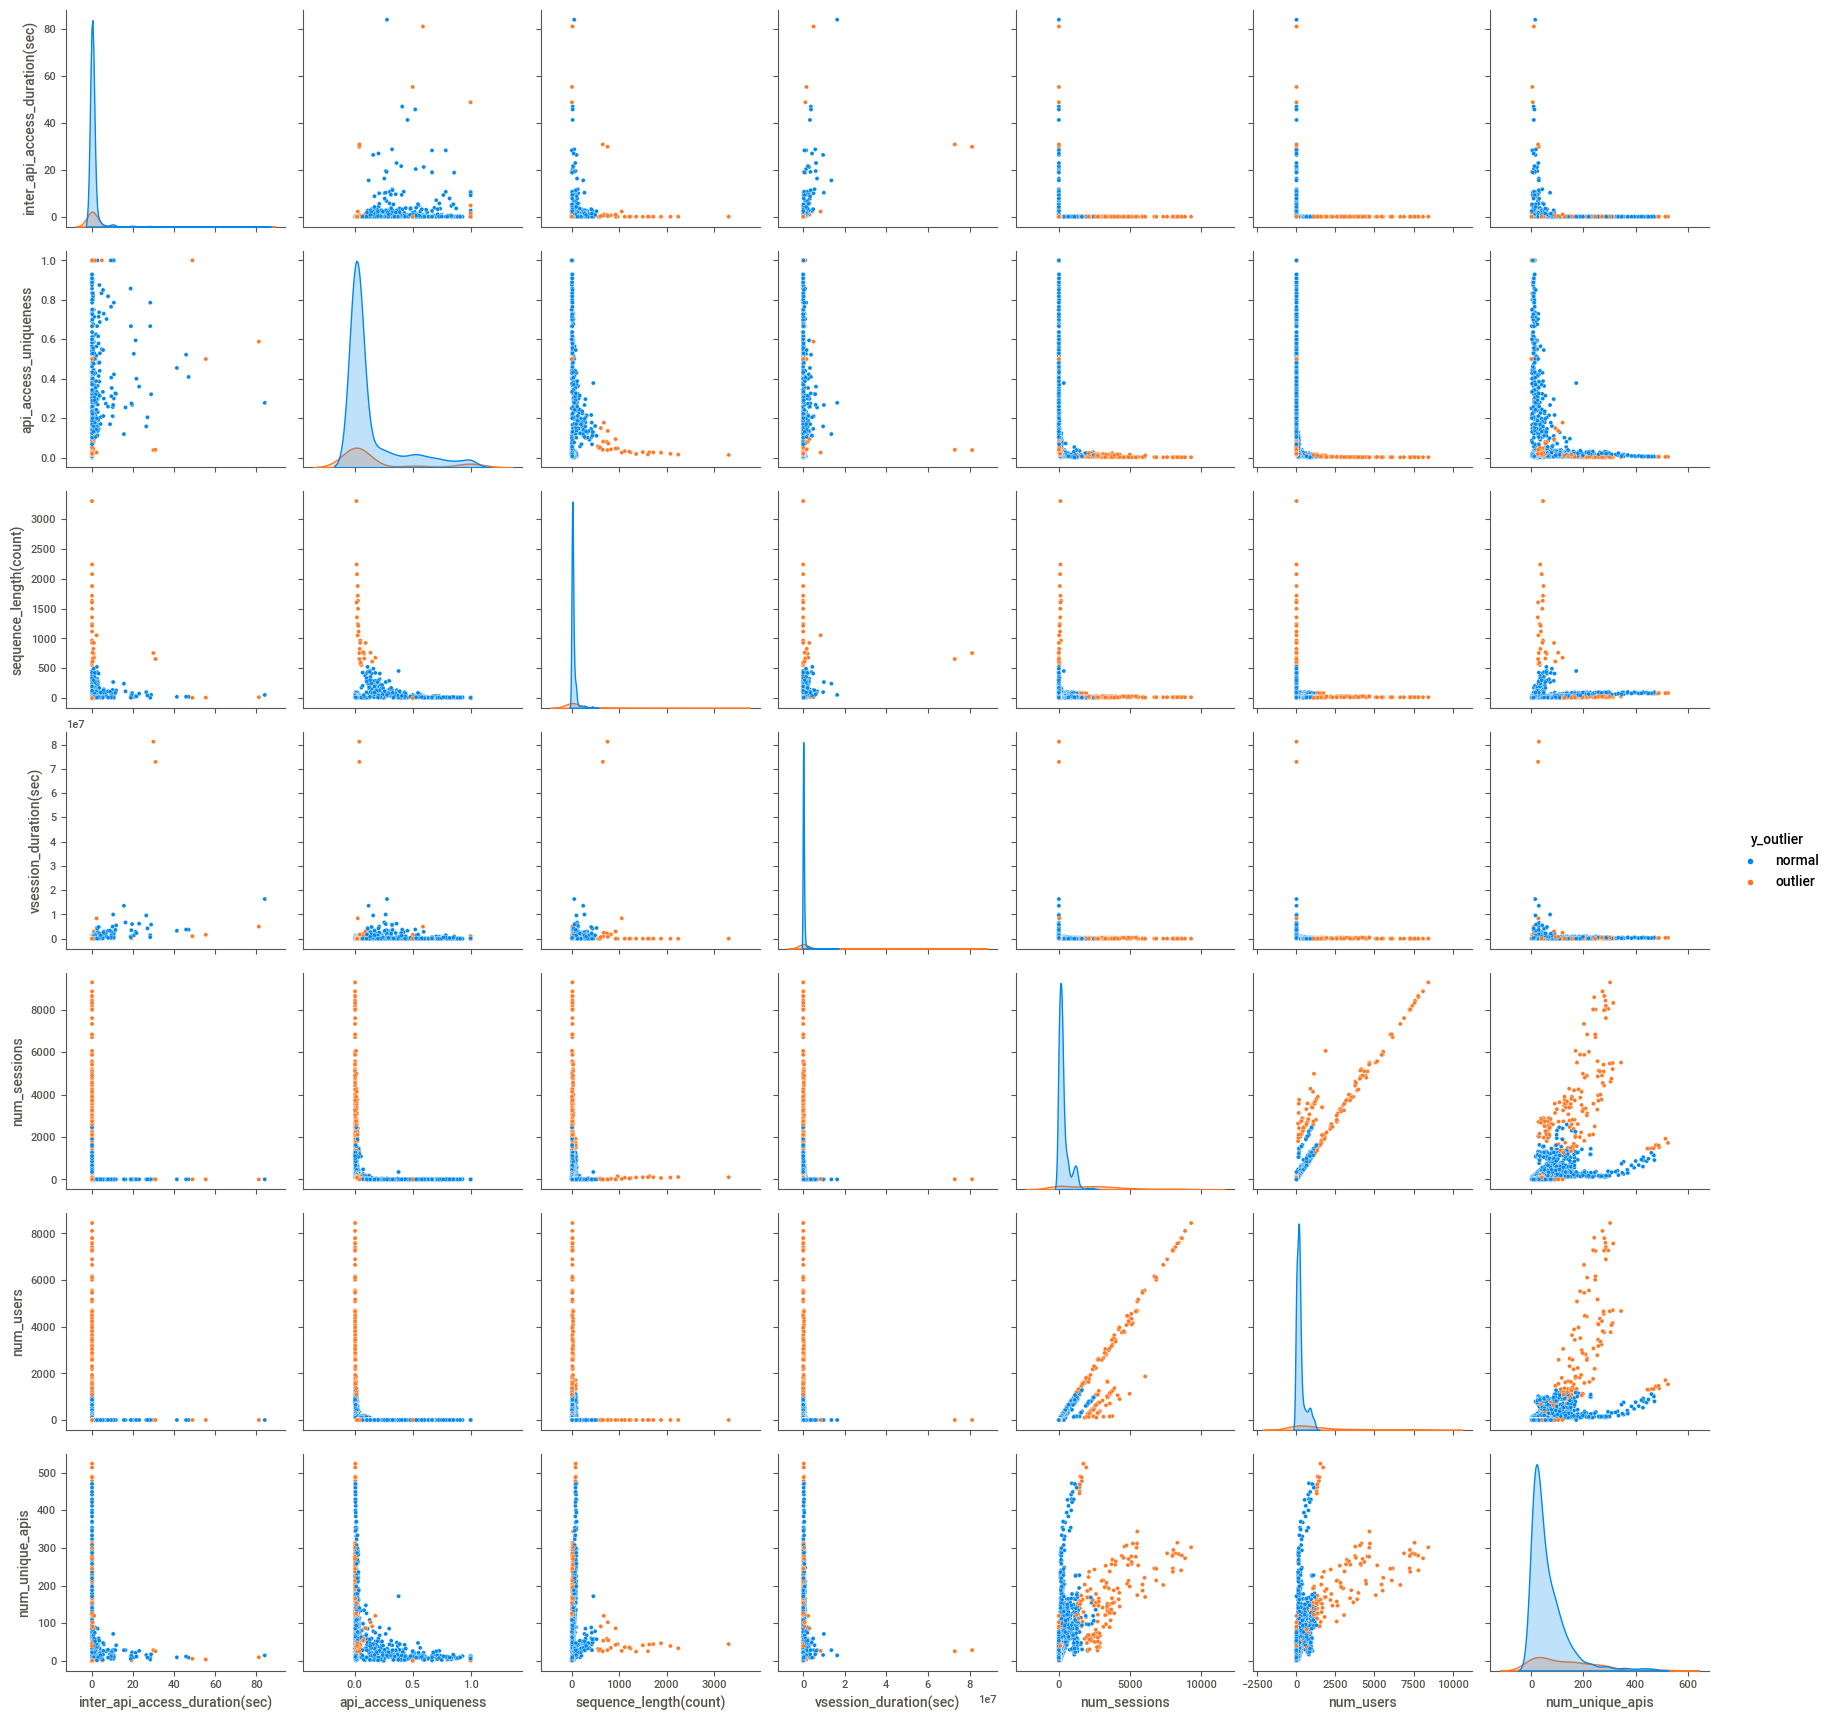

In [92]:
sns.pairplot(data=df_pred, hue = 'y_outlier')

### Considerando solamente 2 características en el ajuste del One-Class SVM

- **num_sessions:** Número de sesiones de usuario cada una con diferente session_id.
- **num_users:** Número de usuarios generando el mismo tipo de secuencias de llamadas de API.

In [93]:
# dataframe con las 4 características
df_subset = df_sup_num.copy()
df_subset = df_subset[['num_users','num_sessions']]
df_subset.head()

# ajustar el hiperparametro
clf = OneClassSVM(nu=0.15, kernel='rbf')
# predicciones de los outliers
# el método regresa 1 para no outliers y -1 para outliers
y_outlier = clf.fit_predict(df_subset)

In [94]:
y_outlier.shape

(1534,)

In [95]:
np.unique(y_outlier, return_counts=True)

(array([-1,  1]), array([ 164, 1370]))

In [96]:
# agregar la columna con las predicciones a nuevo dataframe, codificadas como outlier, normal
df_pred = df_sup_num.copy()
df_pred['y_outlier'] = np.where(y_outlier > 0, 'normal', 'outlier')
df_pred['y_outlier'] = df_pred['y_outlier'].astype('category')

df_pred.head()

inter_api_access_duration(sec)  api_access_uniqueness  \
0                        0.000812               0.004066   
1                        0.000063               0.002211   
2                        0.004481               0.015324   
3                        0.017837               0.014974   
4                        0.000797               0.006056   

   sequence_length(count)  vsession_duration(sec)  num_sessions  num_users  \
0               85.643243                  324300        1460.0     1295.0   
1               16.166805                   31140        9299.0     8447.0   
2               99.573276                  372660         255.0      232.0   
3               69.792793                  497520         195.0      111.0   
4               14.952756                   10920         272.0      254.0   

   num_unique_apis y_outlier  
0            451.0   outlier  
1            302.0   outlier  
2            354.0    normal  
3            116.0    normal  
4             23.0    normal

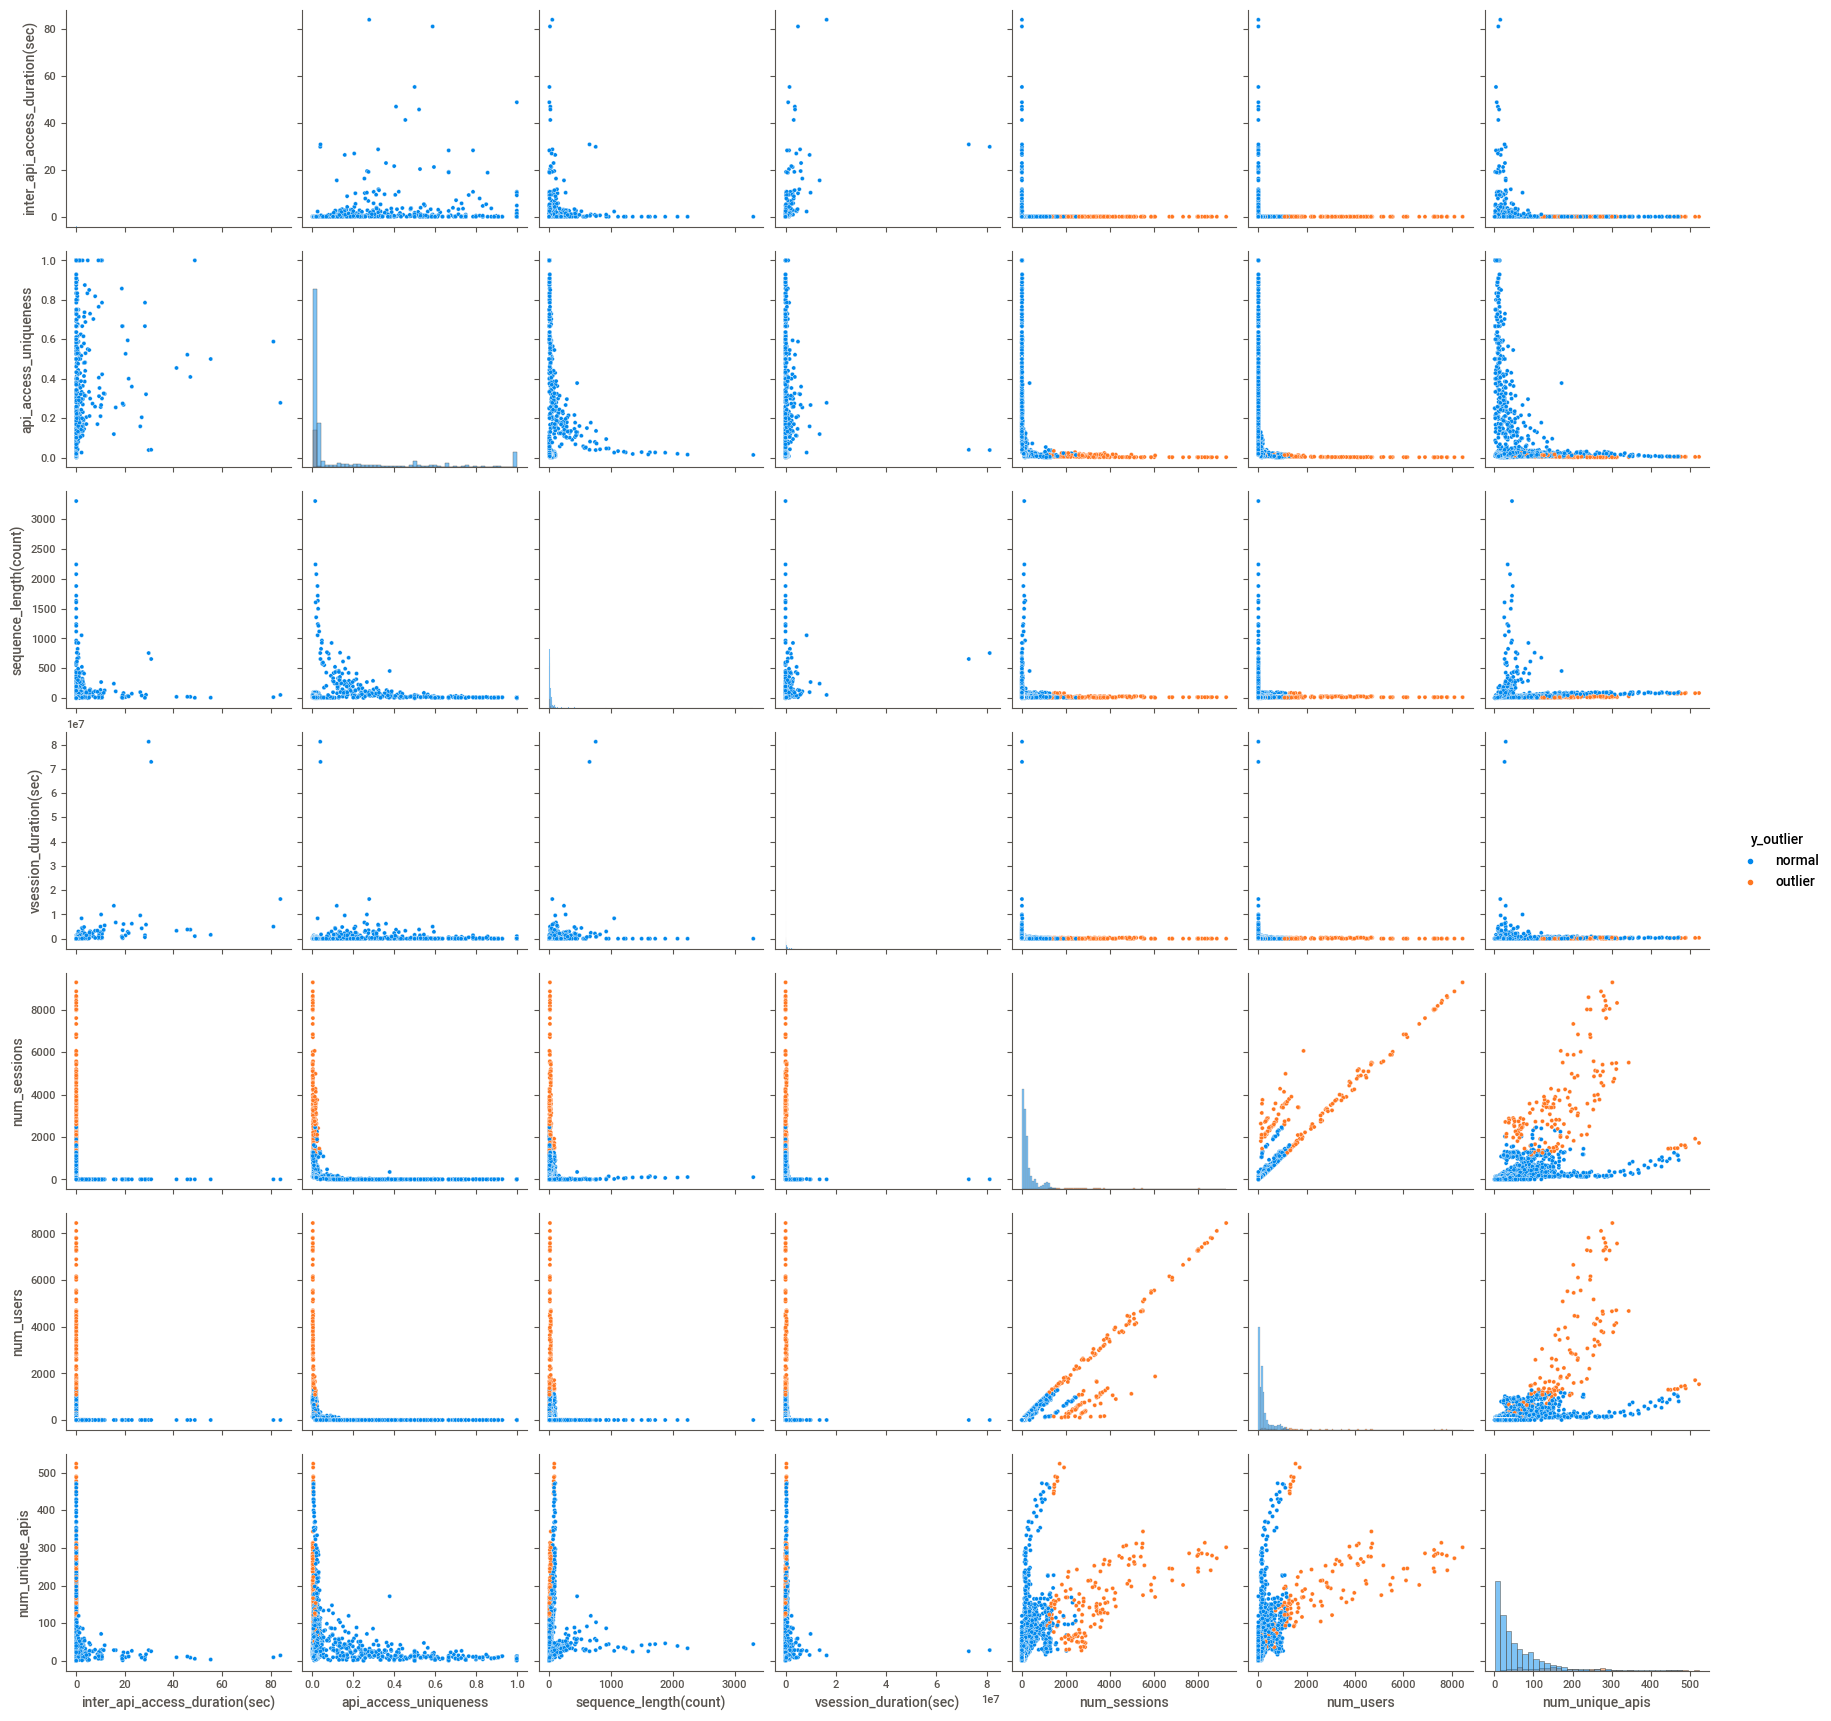

In [98]:
sns.pairplot(data=df_pred, hue = 'y_outlier', diag_kind='hist')

## Conclusiones
como es de esperarse, al aplicar el método OC-SVM a las 7 variables numéricas, podemos ver que en todas las gráficas de pares se encuentran outliers. Mientras que se van considerando menos variables para la filtración de los outliers, se encuentran menos.

En este caso se fijo el parámetro ```nu = 0.15```  para considerar la misma proporción de outliers en los 3 casos.  

Considerando solo las variables de número de sesiones y número de usuarios vemos que se quedan algunas gráficas de pares sin filrar datos outliers.

El caso equilibrado parece ser considerar las variables de tiempo junto con las de sesiones, que son las siguientes

- **inter_api_access_duration(sec)** 
- **sequence_length(count)**
- **num_sessions** 
- **num_users** 

Parece filtrar bien como se observa en las gráficas de número de sesion y número de usuario contra el número de llamads únicas a la API, dejando un comportamiento que se ajustaría bien con una regresión lineal. 

Por otro lado, para la gráfica de número de usuarios contra número de sesiones parece filtrar excesivamente y romper la tendencia de linealidad que se observa.